In [1]:

import numpy as np
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)  Naive Bayes classifier
Week 10 | 5.1

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Describe Naive Bayes
- Choose a Naive Bayes implementation based on your use case
- Implement a Naive Bayes model through scikit-learn



### Bayes' thereom, again:


 $$P\left(\;A\;|\;B\;\right) = \frac{P\left(\;B\;|\;A\;\right)P\left(\;A\;\right)}{P(\;B\;)}$$


 $$P\left(\;model\;|\;data\;\right) = \frac{P\left(\;data\;|\;model\;\right)P\left(\;model\;\right)}{P(\;data\;)} $$


## Recall our coin flipping example

What was $P(model)$?

The prior assumption about the distribution of p (the probability of getting heads).

## Dimensionality

In that case, we had only one model parameter ($p$) to solve for.  So our $P(model)$ was a two dimensional probability density function.

What if we had a model with two parameters?  Say, a basic linear regression?

$y = \beta_0 + \beta_1 * x_1$

Now $P(model)$ needs to be a joint probability density of two parameters, namely $\beta_0$ and $\beta_1$.

What might this look like?

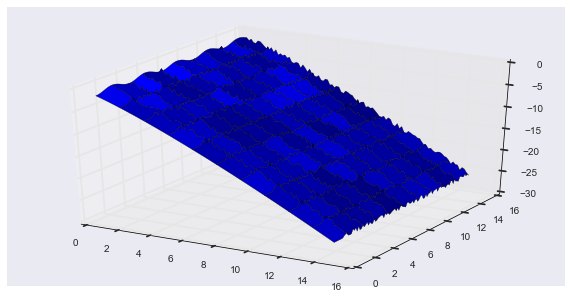

In [18]:
dist = lambda beta, alpha: np.sin(alpha**beta)**2-beta**1.2
beta = np.linspace(1,15, 100)
alpha = np.linspace(0,15, 100)
beta, alpha = np.meshgrid(beta,alpha)
distvec = np.vectorize(dist)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,1,1, projection = '3d')
ax1.plot_surface(beta, alpha, distvec(beta, alpha))

$P(model)$ is now a joint probability density, namely $P(\beta_0, \beta_1)$

Imagine now that you have 1000 features.  How many coefficients would you need to find?

1000 (or more!).  

It can be very computationally difficult to update the prior for full joint probability distribution for all these parameters.

## Naive Bayes 

Naive Bayes, by making some strict assumptions, provides a quicker (and achievable!) way to use Bayes-type models.

And surprisingly, despite these strict assumptions, it performs quite well!

We can use this for classification problems.\* 

Its canonical use case is spam classification (or text classification generally), where it has proven to be rather effective.




<sub>\*Or regression. But it doesn't work well.</sub>

### Let's look at a really simple example

We are trying to predict spam emails.  For now, we have one feature: whether the email mentions "guarantee"

G = 'guarantee', S = 'is spam'.

 $$P\left(\;S\;|\;G\;\right) = \frac{P\left(\;G\;|\;S\;\right)P\left(\;S\;\right)}{P(\;G\;)} = \frac{P\left(\;G\;|\;S\;\right)P\left(\;S\;\right)}{P(\;G\;|\;S)P(\;S\;) + P(\;G\;|\;\neg{S})P(\;\neg{S}\;)}$$



We can make some simplifying assumptions. Let's start by assuming an equal chance of spam / not spam. So:

### $$ P\left(\;S\;|\;G\;\right) =
\frac{P\left(\;G\;|\;S\;\right)}
{P(\;G\;|\;S) + P(\;G\;|\;\neg{S})}$$


But, in all likelihood, we'd use more than one feature. Really, we want to see some feature vector $X_1, X_2, ..., X_n$:

$$P\left(\;S\;|\;X_1, ..., X_n\;\right) = \frac{P\left(\;X_1,  ..., X_n\;|\;S\;\right)}{P(\;X_1,  ..., X_n\;|\;S) + P(\;X_1, ..., X_n\;|\;\neg{S})}$$

Since these features can take on different values in each observation, our calculation is really:

$$P\left(\;S\;|\;X_{1=x1}, ... X_{n=xn}\;\right) = \frac{P\left(\;X_{1=x1}, ... X_{n=xn}\;|\;S\;\right)}{P(\;X_{1=x1},  ... X_{n=xn}\;|\;S) + P(\;X_{1=x1},  ... X_{n=xn}\;|\;\neg{S})}$$



For example, what is the likelihood that something is spam given that the email mentions "guarantee", "millions", "oil", "fund", but not "hobby", "vacation" or "existentialism".

>Check: based on the above example, what are my features?  What type of features are they?



With a lot of features, calculating their joint probabilities could get really complicated really quickly.

## Recall that

### $$ P(A \cap B) = P(A|B) \; P(B) $$


In the above formulation, are A and B 
- a) disjoint?
- b) independent?
- c) no idea?

In reality, model parameters / coefficients are unlikely to be independent.  But Naive Bayes makes exactly this assumption.

Specifically, it assumes that the $X_i$ is independent of all the other $X$, conditional on $Y$

### Here's how it simplifies

If we *assume independence*: 

$P\left(\;X_{1=x1}, X_{2=x2}, ..., X_{n=xn}\;|\;S\;\right) = P\left(\;X_{1=x1} |\;S\;\right) * P\left(\;X_{2=x2} |\;S\;\right) ... P\left(\;X_{n=xn} |\;S\;\right)$

$$P\left(\;S\;|\;X_{1=x1}, X_{2=x2}, ..., X_{n=xn}\;\right) = \prod_{i=1}^{n}P(X_i = x_i | \;S\;) / C$$

Where C is some constant for our marginal probability of those data (i.e. the evidence).

This is much easier to calculate!

## Ok, but we're still in Bayes territory, with distributions... how do I make a single prediction?

We discussed a few ways to make point estimates on Monday / Tuesday.  What were they?

We could find the most probable value for Y (or in other words, given the data we've collected, which is the most likely class).  

This is the maximum likelihood.

### This gives a handy decision function (generalizable to k classes)
<img src = "./assets/images/nb_decision_rule.png" width = 600px>

## Back to our spam email example

Reminder: we want to classify an email as spam or ham.  

In order to do this, we are going to calculate the probability that it's spam, and the probability that it's ham, and classify according to the larger of the two.


To calculate the probability that it's spam, we are going to multiply all the conditional probabilities for the features.  

In plain english, the probability that an email is spam given that it contains the words "millions", "guarantee" and "urgent" is proportional to the product of 
- the probability that an email contains the word "millions" given that it is spam
- the probability that an email contains the word "guarantee" given that it is spam
- the probability that an email contains the word "urgent" given that it is spam

## So how to we calculate those probabilities?  

We could assume uniform probabilities.

Or we could use our dataset to inform us.  This is what sklearn does by default.

## For example, let's assume one of features of our model is number of words (and for simplicity, we'll assume this is normally distributed)

We could first look at all the spam emails in our training set, and calculate the mean and standard deviation for the number of words.

Then we do the same for all the ham emails. 

Let's say
- for spam emails, the mean is 99 and standard deviation is 15.
- for ham emails, the mean is 45 and standard deviation is 3. 


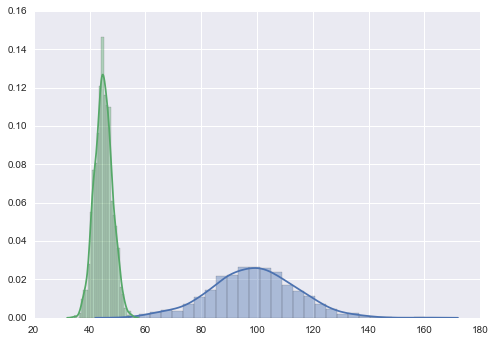

In [3]:
spams = np.random.randn(1000)*15+99
hams = np.random.randn(1000)*3+45
sns.distplot(spams)
sns.distplot(hams);

Let's say we have an email with 47 words.  

Given the above distributions, we could calculate the probability that this email is spam, and the probability that it's ham, and classify according to the higher of the two.

Just by eyeballing, which class do you think it belongs to?

## What about with more than one feature?

Now we just multiply the probabilities together.

$S$ means the email is spam<br>
$l$ is the number of words in the email<br>
$w$ is the average word length in the email

$$P(S|l = 25, w = 7) \propto P(l = 25 |S)*P(w = 7 |S)$$

## Type of features

We're still in Bayes land, so we still want to take into account distributions of beliefs.

In order to calculate the probability of seeing a specific feature value, we need to make an assumption about the probability distribution of that feature.

For example, is it normally distributed (Gaussian)?

$P\left(\;X_{1=x1}, X_{2=x2}, ..., X_{n=xn}\;|\;S\;\right)$

For a binary event, probability can be modeled with the **binomial distribution**.

For > 2 discrete outcomes, the **multinomial distribution**.

And if features are real-valued? **Gaussian**.
 
<img src = "./assets/images/naive-bayes.png"> 

## In Sklearn


- [Docs 1](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [Docs 2](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
- [Docs 3](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html)

The differences can be summarized as follows
-    ***BernoulliNB*** is designed for binary/boolean features
-    The ***multinomial Naive Bayes classifier*** is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as `tf-idf` may also work
-    ***GaussianNB*** is designed for continuous features (that can be scaled between 0,1) and is assumed to be normally distributed

### Moving toward a production implementation

Possible issues to contend with:




- [Underflow](http://stackoverflow.com/questions/3704570/in-python-small-floats-tending-to-zero). Probabilites may very very small, too small for floating point arithmetic. We can solve by leveraging:

$$log(ab) = log\ a + log\ b$$

$$exp(log\ x) = x$$

So $P_1\ *\ P_2\ ...\ *\ P_2 = exp(log\ P_1 + ... + log\ P_n)$


- '0' probabilities. What if you never saw a feature value in your training data? We can use Laplace smoothing:

$$\hat\theta_i= \frac{x_i + \alpha}{N + \alpha d}  \qquad (i=1,\ldots,d)$$

Where $\alpha > 0$ is the smoothing parameter.

## Guided practice: Scikit-learn implementation

In [4]:
from sklearn import naive_bayes
import numpy as np
import pandas as pd

data = pd.read_csv('./assets/datasets/spam_base.csv')

In [5]:
data.head()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278,1
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


> Check: what do you think is going on with this dataset?

> Which sklearn NB implementation should we use?

In [6]:
feature_set = data.iloc[:, :-1]
target = data.iloc[:, -1]

classifier1 = naive_bayes.MultinomialNB().fit(feature_set, target)

In [7]:
from sklearn.model_selection import cross_val_score
print cross_val_score(classifier1, feature_set, target)

[ 0.78943937  0.81996086  0.73581213]


> Check: is that good?

In [8]:
np.sum(target) / len(target)

0.3939130434782609

<a name = "conclusion"></a>
## Conclusion (5 min)


How does Naive Bayes fit into your toolkit? What are the pros and cons? How do you choose between variants?

#### Additional Resources

- [An interesting slide from a Stanford MOOC which had a section on Naive Bayes](https://web.stanford.edu/class/cs124/lec/naivebayes.pdf)
- [A much more technical paper comparing Naive Bayes to Logistics Regressions](https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf)
- [More exposition on Naive Bayes](http://blog.yhat.com/posts/naive-bayes-in-python.html)
- [Naive Bayes from scratch](http://machinelearningmastery.com/naive-bayes-classifier-scratch-python/)